# Inspecting the 2011 GBT Raster Scan data set


### Before doing anything, you must download the data.
1. [Catalog1](http://classy.astro.berkeley.edu/data/KeplerRasterScan_1.4-1.5Ghz.all.txt)
1. [Catalog2](http://classy.astro.berkeley.edu/data/KeplerRasterScan_1.4-1.5Ghz.trimmed.txt)
1. [DataFiles](http://classy.astro.berkeley.edu/data/KeplerGBT1.4-1.5Ghz.tgz) (7.3 GB tarfile!)

-----------------------------

This data set was observed in 2011 by scanning back and forth (a [raster scan pattern](http://www.aanda.org/articles/aa/full/2007/41/aa7811-07/img52.gif) with the GBT over
the entire [Kepler field](https://en.wikipedia.org/wiki/Kepler_(spacecraft)) - i.e. the patch of sky the original Kepler mission observed.  This took about 11 hours, and the telescope was observing between 1.1 and 1.9 GHz.  Because the telescope was moving continuously over the sky, the dimensions of time and the 1-D position along the scan path cannot be disentagled.

The data were recorded to disk in the raw "baseband voltage" format, and I searched through them for bright and relatively narrow-band signals.  This search was run by using a GPU-accelerated code to produce power spectra with effective integration times of ~4.8 seconds and resolutions of ~3 Hz.  In these spectra, I searched for all signals with a signal-to-noise ratio greater than 10.0 (after correcting for Doppler drifts between $\pm$10 Hz).

If a detected signal obviously persists for more than ~16 seconds (the time it takes the telescope to move ~15 arcminutes on the sky), then I know that the signal did not come from space and is local radio interference (i.e. it is "confined" on the sky).  A steady signal from a single point in space would only be detected as the telescope scanned over that spot.  If the signal could possibly have originated from a single point in space, I recorded a slice of that signal in a "waterfall plot" and recorded  some metadata (the signal-to-noise ratio, the time, and the coordinates on the sky we detected it).  If the signal did not pass our cut, however, then I only recorded the metadata in a big database and did not keep a waterfall plot.

Because my code scanned the data in a rolling window averaging manner, and because many signals vary in brightness a lot over time, many bright signals were detected more than once.  In addition, the first pass through the data recorded many signals that passed my simple confined/not-confined algorithm but really weren't.  I trimmed this data set by implementing a more rigorous confined/not-confined test and by identifying all duplicates.

For this demo notebook, I've packaged up the data from 1.4 to 1.5 GHz, which includes the hydrogen 21cm/1420MHz zone (a frequency that has historically been important for SETI searches).  This is ~1/8th of the total data from this data set, and I can package up and make available the rest of it if requested.

The major goal is to identify sources of radio-wavelength flux from here on earth (Radio Frequency Interference, or RFI) from any possible signal from an astronomical source.  RFI is common, diverse, and pernicious.

----------------------------------------

__KeplerGBT1.4-1.5Ghz.tgz__:
A huge tarball of all waterfall plots between 1.4 and 1.5 Ghz.  Unpack with the command ``tar -xvzf KeplerGBT1.4-1.5Ghz.tgz``.  Uncompressed numpy arrays are saved in folders grouped by scan row (the telescope scanned back and forth 90 times over 11 hours to cover the whole field).

__KeplerRasterScan_1.4-1.5Ghz.all.txt__:
A text catalog with metadata for every waterfall plot included.

__KeplerRasterScan_1.4-1.5Ghz.trimmed.txt__:
A text catalog with metadata for only those waterfall plots that pass the more rigorous second-pass cuts.  I recommend you examine only these files.


# Imports and definitions

In [35]:
%pylab inline
import os

DATADIR = '/media/Flipper/seti_search'  # path to your copy of the data
CATDIR = '/media/Flipper/seti_search/tarballs' # path to your copy of the text catalogs


Populating the interactive namespace from numpy and matplotlib


In [36]:
def plotone( f, log=False, rootdir=DATADIR ):
    """Plot a single waterfall plot with labeled axes"""
    dtime = 0.3 #time between tables in a spectrum (s)
    dangle = 0.53 #angular distance between tables in a spectrum (arcmin)
    d = np.load( os.path.join(rootdir,f) )
    fqs = d[0,:]
    l = d.shape[0] - 1
    plt.figure()
    if log:
        plt.pcolor( fqs, np.arange(-l/2,l/2), np.log10(d[1:,:]) )
        c = plt.colorbar()
        c.set_label('Log10 SNR')
    else:
        plt.pcolor( fqs, np.arange(-l/2,l/2), d[1:,:] )
        c = plt.colorbar()
        c.set_label('SNR')
    # put time on LH side
    ax = plt.gca()
    nt = 7
    ticklocs = np.linspace(-l/2,l/2,nt)
    times = ['%d'%t for t in np.linspace(-dtime*(l/2), dtime*(l/2), nt)]
    ax.set_yticks(ticklocs)
    ax.set_yticklabels(times)
    ax.set_ylabel('Time (s)')
    # put angular seperation on RH side
    ax2 = ax.twinx()
    angseps = ['%d'%t for t in np.linspace(-dangle*(l/2), dangle*(l/2), 7)]
    ax2.set_yticks(ticklocs)
    ax2.set_yticklabels(angseps)
    ax2.set_ylabel('Angular Seperation (arcmin)', rotation=270, color='k')
    ax2.yaxis.set_label_coords( 0.98, 0.5 )
    # x axis is frequency
    nt = 5 #true number one fewer, b/c of space reasons
    x = map(lambda g: round(g,5), np.linspace(fqs[0], fqs[-1], nt)[:-1])
    xlabels = ['%.5f'%g for g in x]
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=-20, ha='left')
    ax.set_xlabel('Frequency (MHz)')
    plt.tight_layout()
    try:
        plt.title( f.split('storage/')[1] )
    except:
        plt.title( f )
    plt.show()

def parse_catalog( f=os.path.join(CATDIR,'KeplerRasterScan_1.4-1.5Ghz.trimmed.txt') ):
    """Parse the text catalogs. RA and Decl. are in decimal degrees, and frequency is in MHz."""
    d = np.genfromtxt( f, skip_header=1, dtype={'names':('path','freq','ra','dec'),
                                               'formats':('|S100',np.float,np.float,np.float)} )
    return d

def plot_kepler_field( ras, decs, kepfile='kepler_field.txt' ):
    """Plot the positions of sources over the Kepler Field"""
    plt.figure()
    # draw all of the corners of the Kepler field
    kepfield = np.loadtxt( kepfile )
    icorners = np.array( [0, 5, 10, 15, 0] )
    for i in set( kepfield[:,0] ):
        # choose one module at a time
        kf = kepfield[ kepfield[:,0] == i ]
        kras = kf[:,10][ icorners ]
        kdecs = kf[:,11][ icorners ]
        plt.plot( kras, kdecs, 'k', lw=3, color='r', alpha=0.5 )
     
    plt.scatter( ras, decs, c='k', marker='.')
    plt.xlabel('R.A.')
    plt.ylabel('Decl.')
    plt.show()

# Examine some waterfall plots

In [37]:
catalog = parse_catalog()

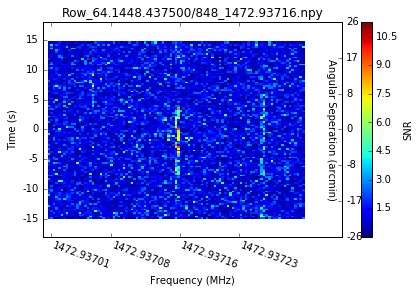

RA: 293.155500
DEC: 46.452100


In [52]:
rando_wf = catalog[np.random.randint(catalog.shape[0])]
plotone( rando_wf['path'] )

print 'RA: %f\nDEC: %f'%(rando_wf['ra'],rando_wf['dec'])

## Signals are strongly clustered in frequency:

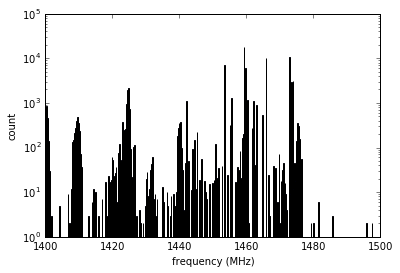

In [53]:
plt.figure()
hist = plt.hist( catalog['freq'], bins=500 )
plt.ylabel('count')
plt.xlabel('frequency (MHz)')
plt.gca().set_yscale('log')
plt.show()

## Signals are not strongly clustered in position on the sky:

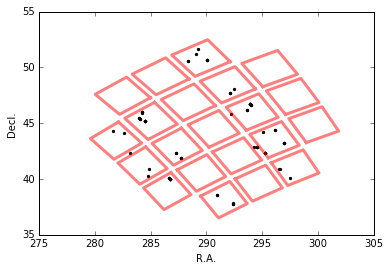

In [54]:
plot_kepler_field( catalog['ra'][:100],catalog['dec'][:100] )

## To do:

- Explore how data is structured: there are many different signal types in this data set.
- Identify subpopulations and outliers.
 - Frequency clustering is powerful, but we want to be able to find interesting signals even if they are near the frequency of an RFI cluster.
 - Any subpopulation that is spread over the sky is definitely RFI, but a subpopulation that comes from one spot on the sky may be interesting! (This search has a spatial resolution of 10-20 arcminutes.)
- Remember that computational speed is important; this data set only represents 1/8th of 11 hours of observation!